In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as tc
#from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [2]:
class Morphism(nn.Module):
    def __init__ (self, name = 'Morphisme R^n --> E', dim_E = 1, neurons = 6):
        print(f'[Model] name : {name}')
        print(f'[Model] dim E : {dim_E}')
        print(f'[Model] no. neurons per layers : {neurons}')
        super(Morphism, self).__init__()
        # layers for plus : E --> E
        self.fc1 = nn.Linear(dim_E, neurons)
        self.fc2 = nn.Linear(neurons, neurons)
        self.fc3 = nn.Linear(neurons, neurons)
        self.fc4 = nn.Linear(neurons, dim_E)

        # dropout layer
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        output = self.fc4(x)
        return output

In [3]:
class InverseMorphism(nn.Module):
    def __init__ (self, name = 'Inverse E --> R^n', dim_E = 1, neurons = 6):
        
        print(f'[Model] name : {name}')
        print(f'[Model] dim E : {dim_E}')
        print(f'[Model] no. neurons per layers : {neurons}')
        super(InverseMorphism, self).__init__()
        # layers for plus : E --> E
        self.fc1 = nn.Linear(dim_E, neurons)
        self.fc2 = nn.Linear(neurons, neurons)
        self.fc3= nn.Linear(neurons, neurons)
        
        self.fc4 = nn.Linear(neurons, dim_E)
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        output = self.fc4(x)
        return output

In [4]:
class LoiBinaire(nn.Module):
    def __init__ (self, name = 'Loi binaire ExE-->E', dim_E = 1, neurons = 6):
        
        print(f'[Model] name : {name}')
        print(f'[Model] dim E : {dim_E}')
        print(f'[Model] no. neurons per layers : {neurons}')
        super(LoiBinaire, self).__init__()
        # layers for plus : ExE --> E
        self.fc1 = nn.Linear(2 * dim_E, neurons)
        self.fc2 = nn.Linear(neurons, neurons)
        self.fc3 = nn.Linear(neurons, neurons)
        self.fc4 = nn.Linear(neurons, dim_E)
    def forward(self, x, y):
        z = torch.cat([x,y], axis=1) # [K,d], [K,d] ---> [K, 2*d]
        z = self.fc1(z)
        z = self.fc2(z)
        z = self.fc3(z)
        output = self.fc4(z)
        return output
# scalaire product of structure

In [5]:
class LoiScalaire(nn.Module):
    def __init__ (self, name = 'Loi Scalaire RxE-->E', dim_E = 1, neurons = 6):
        
        print(f'[Model] name : {name}')
        print(f'[Model] dim E : {dim_E}')
        print(f'[Model] no. neurons per layers : {neurons}')
        super(LoiScalaire, self).__init__()
        # layers for scaler : KxE --> E
        

        self.fc1 = nn.Linear(dim_E, neurons)
        self.fc2 = nn.Linear(neurons, neurons)
        self.fc3 = nn.Linear(neurons, neurons)
        self.fc4 = nn.Linear(neurons, dim_E)
        
        # alpha est un  scalaire,  dim_E est la dimension de l'espace E
        
    def forward(self, alpha, x):
        z = alpha * x # [K,1], [K,d] ---> [K, d]
        z = self.fc1(z)
        z = self.fc2(z)
        z = self.fc3(z)
        output = self.fc4(z)
        return output

In [6]:
class Vect_space(nn.Module):
    def __init__ (self, K,  dim_E = 1 , neurons = 6 , name = 'Groupe (E,+)'):
        super(Vect_space, self).__init__()
        self.f    = Morphism(dim_E = dim_E, neurons = neurons)
        self.fi   = InverseMorphism(dim_E = dim_E, neurons = neurons)
        self.plus = LoiBinaire(dim_E = dim_E, neurons = neurons)
        self.scalaire = LoiScalaire(dim_E = dim_E, neurons = neurons)
        # losses
        self.loss_1 = lambda x, y : torch.linalg.vector_norm(self.plus(x , y) - self.f( self.fi(x) + self.fi(y)) )**2
        self.loss_2 = lambda alpha, x : torch.linalg.vector_norm(self.scalaire(alpha , x) - self.f( alpha*self.fi(x)) )**2

        #  Total loss can be weighted 
        self.loss = lambda x, y, alpha : self.loss_1(x, y) + self.loss_2(alpha, x)
        
    def train(self, X, Y,alpha, optimizer, epoch):
        self.f.train()
        self.fi.train()
        self.plus.train()
        self.scalaire.train()
        losses=[]
        for i in range(epoch):
            L1 = self.loss_1(X, Y)
            L2 = self.loss_2(alpha, X)
            loss = L1 + L2
            #loss = loss.mean()
            if i % 10 == 0:
               print('Epoch {}/{} -\t Loss 1: {:.6f}\t Loss 2: {:.6f}\t Total Loss: {:.6f}'.format(i, epoch, L1.item(), L2.item(), loss.item()))
            
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
        return losses

In [7]:
#import numpy as np  
def line(K): #a=2, b=3):
    
    X = 0.3*torch.randn(K, 2).requires_grad_(False)
    Y = 0.3*torch.randn(K, 2).requires_grad_(False)
    alpha = torch.randn(K, 1).requires_grad_(False)
    epislon = 0.1
    X[:,1] = X[:,0] + epislon * torch.sin(X[:,0] / epislon ) # **3 + a*X[:,0] + b
    Y[:,1] = Y[:,0] + epislon * torch.sin(Y[:,0] / epislon) #**3 + a*Y[:,0] + b
    return X, Y, alpha

In [8]:
#import numpy as np  
#def line(K): #a=2, b=3):
 # epislon = 0.1 
  #X = torch.zeros((K, 2))
  #Y = torch.zeros((K, 2))
  #alpha = torch.zeros((K, 2))
  #X[:,0] = torch.linspace(-1, 1, K)
  #X[:,1] = torch.linspace(-1, 1, K)
  #X[:,1] = Y[:,0] + epislon * torch.sin(Y[:,0] / epislon )
  #Y[:,1] = Y[:,0] + epislon * torch.sin(Y[:,0] / epislon )
  #return X, Y, alpha

[Model] name : Morphisme R^n --> E
[Model] dim E : 2
[Model] no. neurons per layers : 64
[Model] name : Inverse E --> R^n
[Model] dim E : 2
[Model] no. neurons per layers : 64
[Model] name : Loi binaire ExE-->E
[Model] dim E : 2
[Model] no. neurons per layers : 64
[Model] name : Loi Scalaire RxE-->E
[Model] dim E : 2
[Model] no. neurons per layers : 64
Epoch 0/1000 -	 Loss 1: 160.248764	 Loss 2: 161.272430	 Total Loss: 321.521179
Epoch 10/1000 -	 Loss 1: 150.641785	 Loss 2: 152.944687	 Total Loss: 303.586487
Epoch 20/1000 -	 Loss 1: 140.926529	 Loss 2: 144.491913	 Total Loss: 285.418457
Epoch 30/1000 -	 Loss 1: 131.389145	 Loss 2: 136.160797	 Total Loss: 267.549927
Epoch 40/1000 -	 Loss 1: 122.101051	 Loss 2: 128.013443	 Total Loss: 250.114502
Epoch 50/1000 -	 Loss 1: 113.097588	 Loss 2: 120.079460	 Total Loss: 233.177048
Epoch 60/1000 -	 Loss 1: 104.402138	 Loss 2: 112.377579	 Total Loss: 216.779724
Epoch 70/1000 -	 Loss 1: 96.033463	 Loss 2: 104.921860	 Total Loss: 200.955322
Epoch 8

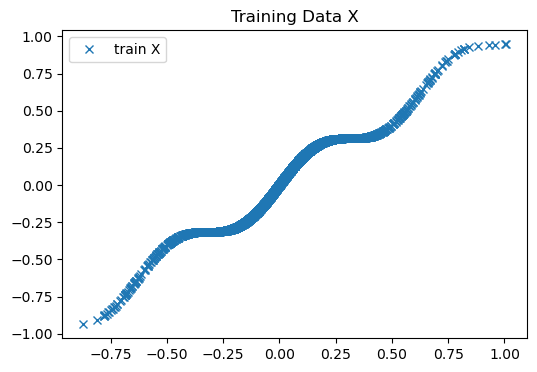

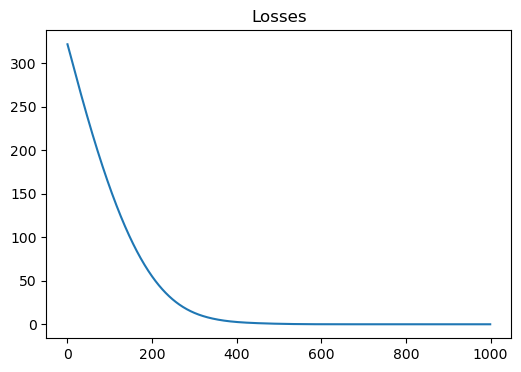

In [9]:
K = 2000
X,Y,alpha = line(K)
dim = 2
G = Vect_space(K, dim_E = dim, neurons = 64)
optimizer = optim.Adadelta(list(G.parameters()), lr=1e-3)
#X = X[:,1]
#Y = Y[:,1]
losses = G.train(X,Y, alpha, optimizer, 1000)
#plt.plot(X[:, 0], X[:, 1], 'x', label='train X')
#plt.plot(Y[:, 0], Y[:, 1], 'o', label='train Y')
#plt.plot(losses);
# Plot training data X
plt.figure(figsize=(6, 4))
plt.plot(X[:,0], X[:,1], 'x', label='train X')
plt.title('Training Data X')
plt.legend()
plt.show()
# Plot training data Y
#plt.figure(figsize=(6, 4))
#plt.plot(Y[:, 0], Y[:, 1], 'o', label='train Y')
#plt.title('Training Data Y')
#plt.legend()
#plt.show()
# Plot losses
plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.title('Losses')
plt.show()

In [10]:
epislon = 0.1

In [11]:
#X = 0.3*torch.randn(K, 2).requires_grad_(False)
#Y = 0.3*torch.randn(K, 2).requires_grad_(False)
#X[:,1] = X[:,0] + epislon * torch.sin(X[:,0] / epislon )
#Y[:,1] = Y[:,0] + epislon * torch.sin(Y[:,0] / epislon )
#print(Y[:-1,0],Y[:-1,1])

In [12]:
X = torch.zeros((K, 2))
Y = torch.zeros((K, 2))
alpha = torch.zeros((K, 1))
X[:,0] = torch.linspace(-1, 1, K)
Y[:,0] = torch.linspace(-1, 1, K)
alpha[:,0] = torch.linspace(0, 1, K)
X[:,1] = X[:,0] + epislon * torch.sin(X[:,0] / epislon )
Y[:,1] = Y[:,0] + epislon * torch.sin(Y[:,0] / epislon )

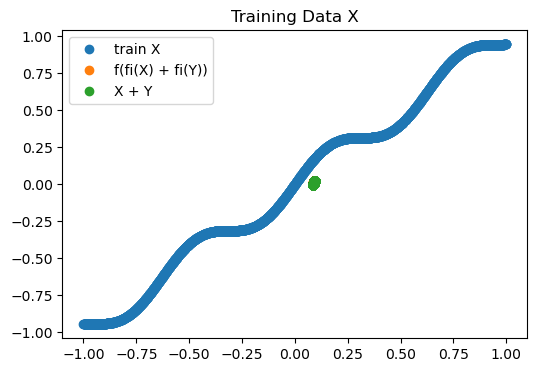

0.14290327


In [13]:
import numpy as np
XXBC =  G.f(G.fi(X) + G.fi(Y))
YYBC = G.plus(X, Y)

plt.figure(figsize=(6, 4))
plt.plot(X[:,0], X[:,1], 'o', label='train X')
plt.plot(XXBC[:,0].detach().numpy(), XXBC[:,1].detach().numpy(), 'o', label='f(fi(X) + fi(Y))')
plt.plot(YYBC[:,0].detach().numpy(), YYBC[:,1].detach().numpy(), 'o', label='X + Y')
plt.title('Training Data X')
plt.legend()
plt.show()

v = np.linalg.norm(XXBC.detach().numpy() - YYBC.detach().numpy())
print(v)



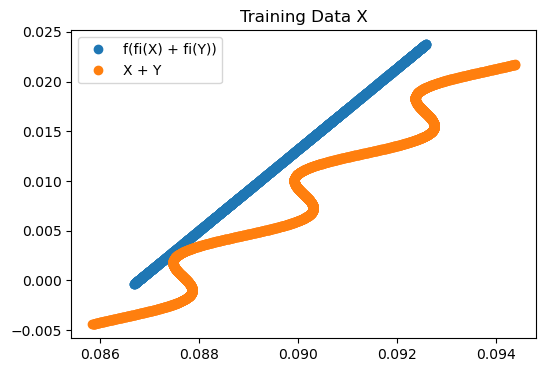

In [14]:
plt.figure(figsize=(6, 4))
plt.plot(XXBC[:,0].detach().numpy(), XXBC[:,1].detach().numpy(), 'o', label='f(fi(X) + fi(Y))')
plt.plot(YYBC[:,0].detach().numpy(), YYBC[:,1].detach().numpy(), 'o', label='X + Y')
plt.title('Training Data X')
plt.legend()
plt.show()

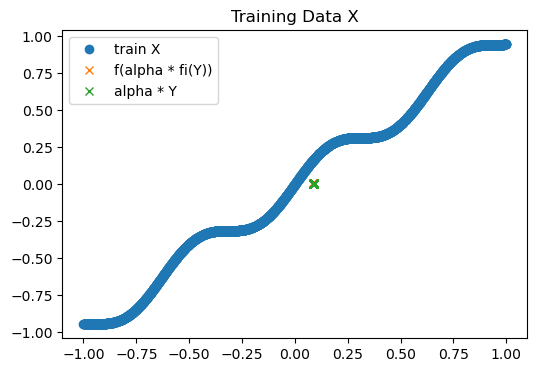

0.117136605


In [15]:
XXBC =  G.f(alpha * G.fi(Y))
YYBC = G.scalaire(alpha, Y)

plt.figure(figsize=(6, 4))
plt.plot(X[:,0], X[:,1], 'o', label='train X')
plt.plot(XXBC[:,0].detach().numpy(), XXBC[:,1].detach().numpy(), 'x', label='f(alpha * fi(Y))')
plt.plot(YYBC[:,0].detach().numpy(), YYBC[:,1].detach().numpy(), 'x', label='alpha * Y')
plt.title('Training Data X')
plt.legend()
plt.show()
v = np.linalg.norm(XXBC.detach().numpy() - YYBC.detach().numpy())
print(v)

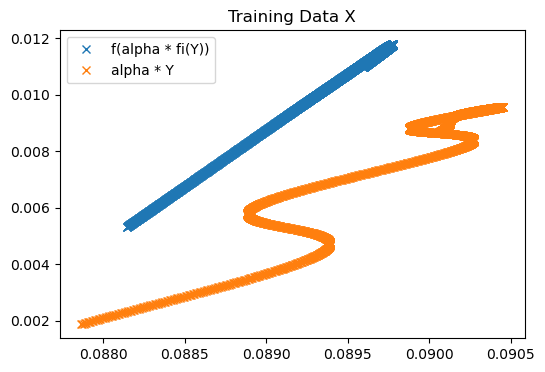

In [16]:
plt.figure(figsize=(6, 4))
plt.plot(XXBC[:,0].detach().numpy(), XXBC[:,1].detach().numpy(), 'x', label='f(alpha * fi(Y))')
plt.plot(YYBC[:,0].detach().numpy(), YYBC[:,1].detach().numpy(), 'x', label='alpha * Y')
plt.title('Training Data X')
plt.legend()
plt.show()

In [17]:
K = 5
B = torch.rand((K, 2))
C = torch.rand((K, 2))
# Générer une valeur aléatoire pour B[0,0]
for i in range(K):
    B[i,1] = B[i,0] + epislon * torch.sin(B[i,0] / epislon )
    C[i,1] = C[i,0] + epislon * torch.sin(C[i,0] / epislon )


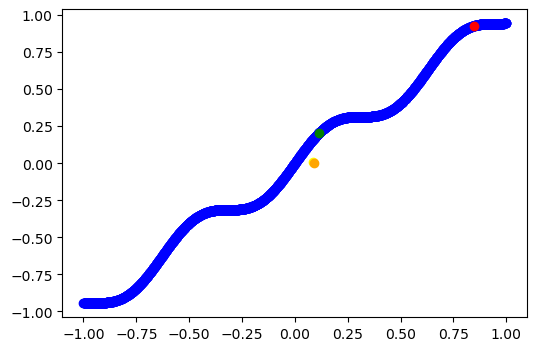

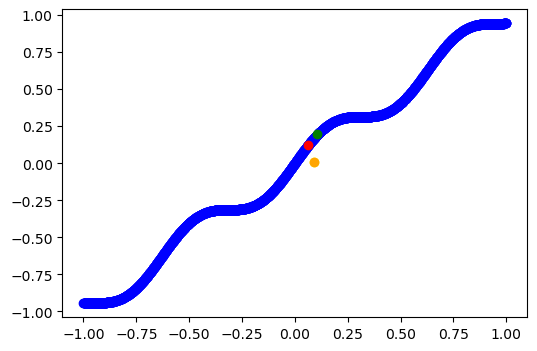

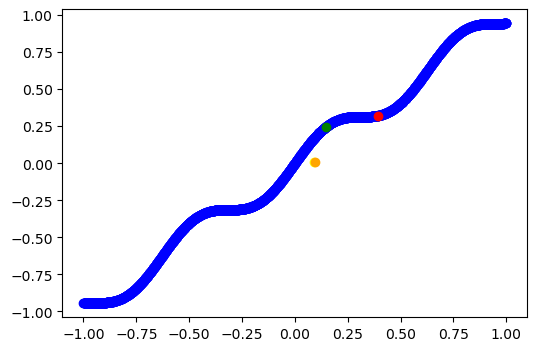

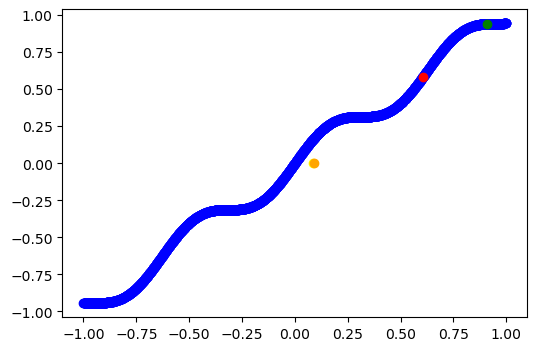

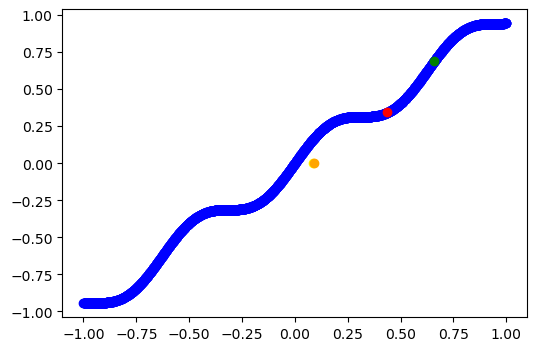

In [18]:
XXBC =  G.f(G.fi(B) + G.fi(C))
YYBC = G.plus(B, C)
# Supposons que X soit une matrice 2D de taille (n, 2)

for i in range(B.shape[0]):
    plt.figure(figsize=(6, 4))
    plt.scatter(X[:, 0], X[:, 1], color='blue')  
    plt.scatter(B[i, 0], B[i, 1], color='green')  # Tracer le point B[i] avec une couleur variable
    plt.scatter(C[i, 0], C[i, 1], color='red')  # Tracer le point C[i] avec une couleur variable
    plt.scatter(XXBC[i, 0].detach().numpy(), XXBC[i, 1].detach().numpy(), color='yellow',label='f(fi(B) + fi(C))')  # Tracer le point XXBC[i] avec une couleur variable
    plt.scatter(YYBC[i, 0].detach().numpy(), YYBC[i, 1].detach().numpy(), color='orange',label='B + C')  # Tracer le point YYBC[i] avec une couleur variable

plt.show()

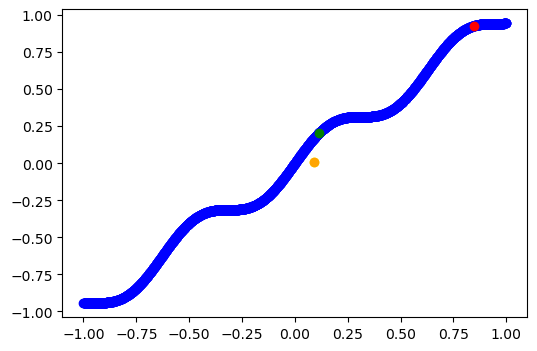

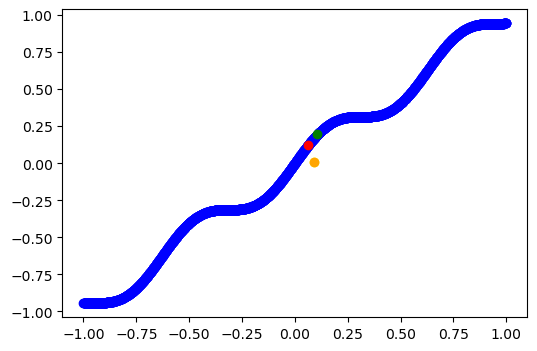

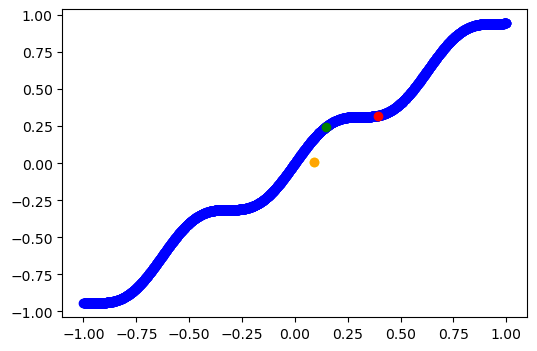

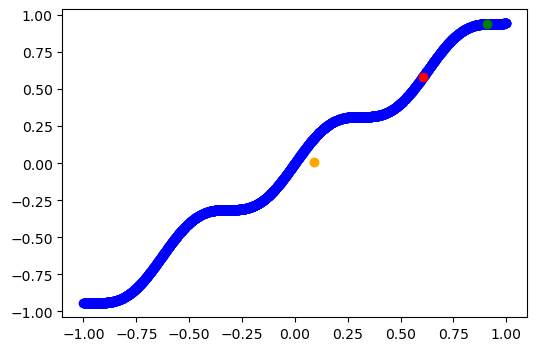

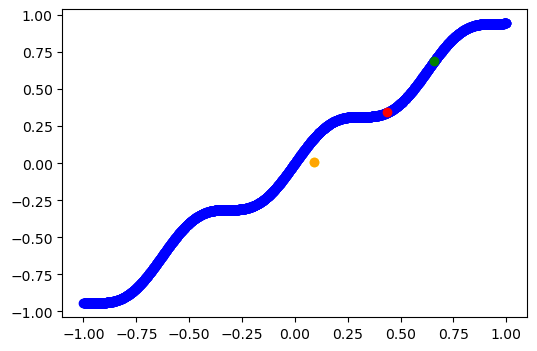

In [19]:
alpha = torch.rand((K, 1))
XXBC =  G.f(alpha * G.fi(C))
YYBC = G.scalaire(alpha, C)
# Supposons que X soit une matrice 2D de taille (n, 2) 
for i in range(B.shape[0]):
    plt.figure(figsize=(6, 4))
    plt.scatter(X[:, 0], X[:, 1], color='blue') 
    plt.scatter(B[i, 0], B[i, 1], color='green')  # Tracer le point B[i] avec une couleur variable
    plt.scatter(C[i, 0], C[i, 1], color='red')  # Tracer le point C[i] avec une couleur variable
    plt.scatter(XXBC[i, 0].detach().numpy(), XXBC[i, 1].detach().numpy(), color='yellow',label='f(fi(B) + fi(C))')  # Tracer le point XXBC[i] avec une couleur variable
    plt.scatter(YYBC[i, 0].detach().numpy(), YYBC[i, 1].detach().numpy(), color='orange',label='B + C')  # Tracer le point YYBC[i] avec une couleur variable

plt.show()

In [20]:
#import numpy as np 
K = 2000 
def line(K): #a=2, b=3):
    
    X = 0.3*torch.randn(K, 3).requires_grad_(False)
    Y = 0.3*torch.randn(K, 3).requires_grad_(False)
    alpha = torch.randn(K, 1).requires_grad_(False)
    epislon = 0.1
    X[:,2] = X[:,0]**2 + X[:,1]**2 # **3 + a*X[:,0] + b
    Y[:,2] = Y[:,0]**2 + Y[:,1]**2 #**3 + a*Y[:,0] + b
    return X, Y, alpha

[Model] name : Morphisme R^n --> E
[Model] dim E : 3
[Model] no. neurons per layers : 64
[Model] name : Inverse E --> R^n
[Model] dim E : 3
[Model] no. neurons per layers : 64
[Model] name : Loi binaire ExE-->E
[Model] dim E : 3
[Model] no. neurons per layers : 64
[Model] name : Loi Scalaire RxE-->E
[Model] dim E : 3
[Model] no. neurons per layers : 64
Epoch 0/1000 -	 Loss 1: 35.721592	 Loss 2: 89.682930	 Total Loss: 125.404526
Epoch 10/1000 -	 Loss 1: 32.833611	 Loss 2: 83.891655	 Total Loss: 116.725266
Epoch 20/1000 -	 Loss 1: 30.043341	 Loss 2: 78.123260	 Total Loss: 108.166603
Epoch 30/1000 -	 Loss 1: 27.430424	 Loss 2: 72.546196	 Total Loss: 99.976624
Epoch 40/1000 -	 Loss 1: 25.003658	 Loss 2: 67.193726	 Total Loss: 92.197388
Epoch 50/1000 -	 Loss 1: 22.760275	 Loss 2: 62.076527	 Total Loss: 84.836800
Epoch 60/1000 -	 Loss 1: 20.694180	 Loss 2: 57.198433	 Total Loss: 77.892609
Epoch 70/1000 -	 Loss 1: 18.798225	 Loss 2: 52.560787	 Total Loss: 71.359009
Epoch 80/1000 -	 Loss 1: 17

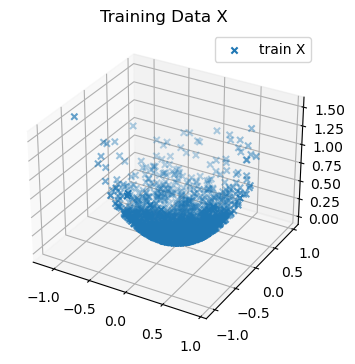

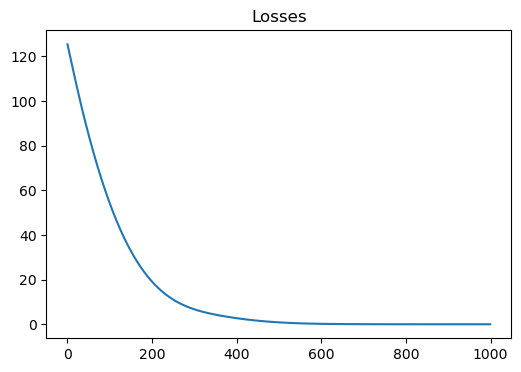

In [21]:
from mpl_toolkits.mplot3d import Axes3D
K = 2000
X,Y,alpha = line(K)
dim = 3
G = Vect_space(K, dim_E = dim, neurons = 64)
optimizer = optim.Adadelta(list(G.parameters()), lr=1e-3)
#X = X[:,1]
#Y = Y[:,1]
losses = G.train(X,Y, alpha, optimizer, 1000)
#plt.plot(X[:, 0], X[:, 1], 'x', label='train X')
#plt.plot(Y[:, 0], Y[:, 1], 'o', label='train Y')
#plt.plot(losses);
# Plot training data X
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='x', label='train X')
ax.set_title('Training Data X')
ax.legend()
plt.show()
# Plot training data Y
#plt.figure(figsize=(6, 4))
#plt.plot(Y[:, 0], Y[:, 1], 'o', label='train Y')
#plt.title('Training Data Y')
#plt.legend()
#plt.show()
# Plot losses
plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.title('Losses')
plt.show()

In [22]:
X,Y,alpha = line(K)
XXBC =  G.f(G.fi(X) + G.fi(Y))
YYBC = G.plus(X, Y)
print(XXBC.shape)
print(XXBC.shape)






fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='x', label='train X')
plt.scatter(XXBC[:,0].detach().numpy(), XXBC[:,1].detach().numpy(),XXBC[:,2].detach().numpy(),marker= 'o', label='f(fi(X) + fi(Y))')
plt.scatter(YYBC[:,0].detach().numpy(), YYBC[:,1].detach().numpy(),YYBC[:,2].detach().numpy(),marker= 'o', label='X+Y')
ax.set_title('Training Data X')
ax.legend()
plt.show()


torch.Size([2000, 3])
torch.Size([2000, 3])


/usr/lib/python3/dist-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


ValueError: need at least one array to concatenate

<Figure size 600x400 with 1 Axes>

In [23]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(XXBC[:,0].detach().numpy(), XXBC[:,1].detach().numpy(),XXBC[:,2].detach().numpy(),marker= 'o', label='f(fi(X) + fi(Y))')
plt.scatter(YYBC[:,0].detach().numpy(), YYBC[:,1].detach().numpy(),YYBC[:,2].detach().numpy(),marker= 'o', label='X+Y')
ax.set_title('Training Data X')
ax.legend()
plt.show()

ValueError: need at least one array to concatenate

<Figure size 600x400 with 1 Axes>

In [24]:
K = 5
B = torch.rand((K, 3))
C = torch.rand((K, 3))
alpha = torch.rand((K, 1))
# Générer une valeur aléatoire pour B[0,0]
for i in range(K):
    B[i,2] = B[i,0]**2 + B[i,1]**2
    C[i,2] = C[i,0]**2 + C[i,1]**2


tensor([[-0.0272,  0.0595, -0.0240],
        [-0.0410,  0.0591, -0.0244],
        [-0.0473,  0.0609, -0.0214],
        [-0.0333,  0.0608, -0.0215],
        [-0.0354,  0.0543, -0.0329]], grad_fn=<AddmmBackward0>)


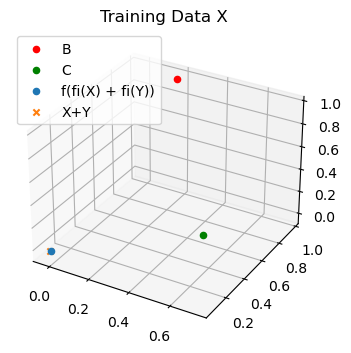

In [25]:
XXBC =  G.f(G.fi(B) + G.fi(C))
YYBC = G.plus(B, C)
# Supposons que X soit une matrice 2D de taille (n, 2)
print(XXBC)



fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='x', label='train X')
ax.scatter(B[0,0], B[0,1],B[0,2],marker= 'o', color='red' ,label='B')
ax.scatter(C[0,0], C[0,1],C[0,2],marker= 'o',color='green', label='C')
ax.scatter(XXBC[0,0].detach().numpy(), XXBC[0,1].detach().numpy(),XXBC[0,2].detach().numpy(),marker= 'o', label='f(fi(X) + fi(Y))')
ax.scatter(YYBC[0,0].detach().numpy(), YYBC[0,1].detach().numpy(),YYBC[0,2].detach().numpy(),marker= 'x', label='X+Y')
ax.set_title('Training Data X')
ax.legend()
plt.show()

In [26]:
print(XXBC)
print(YYBC)
for i in range(len(XXBC)): 
    g = np.linalg.norm(XXBC[i].detach().numpy() - YYBC[i].detach().numpy())
    print(g)

tensor([[-0.0272,  0.0595, -0.0240],
        [-0.0410,  0.0591, -0.0244],
        [-0.0473,  0.0609, -0.0214],
        [-0.0333,  0.0608, -0.0215],
        [-0.0354,  0.0543, -0.0329]], grad_fn=<AddmmBackward0>)
tensor([[-0.0294,  0.0593, -0.0229],
        [-0.0426,  0.0581, -0.0231],
        [-0.0497,  0.0606, -0.0205],
        [-0.0340,  0.0593, -0.0196],
        [-0.0371,  0.0533, -0.0316]], grad_fn=<AddmmBackward0>)
0.0025482364
0.0023174353
0.0026264729
0.002530831
0.0023919079


tensor([[-0.0431,  0.0550, -0.0310],
        [-0.0388,  0.0536, -0.0336],
        [-0.0414,  0.0530, -0.0346],
        [-0.0387,  0.0573, -0.0273],
        [-0.0380,  0.0525, -0.0356]], grad_fn=<AddmmBackward0>)


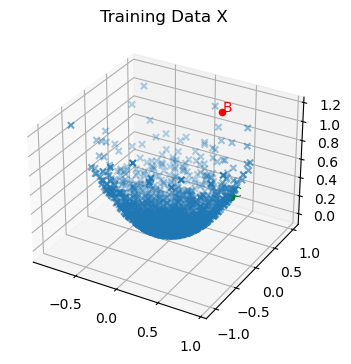

In [34]:
XXBC =  G.f(alpha * G.fi(C))
YYBC = G.scalaire(alpha, C)
# Supposons que X soit une matrice 2D de taille (n, 2)
print(XXBC)



fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='x', label='train X')
ax.scatter(B[0,0], B[0,1],B[0,2],marker= 'o', color='red' ,label='B')
ax.text(B[0,0], B[0,1], B[0,2], 'B', color='red')
ax.scatter(C[0,0], C[0,1],C[0,2],marker= 'o',color='green', label='C')
ax.text(C[0,0], C[0,1], C[0,2], 'C', color='green')
ax.scatter(XXBC[0,0].detach().numpy(), XXBC[0,1].detach().numpy(),XXBC[0,2].detach().numpy(),marker= 'o', label='f(fi(X) + fi(Y))')
ax.text(XXBC[0,0].detach().numpy(), XXBC[0,1].detach().numpy(), XXBC[0,2].detach().numpy(), 'XXBC', color='yellow')
ax.scatter(YYBC[0,0].detach().numpy(), YYBC[0,1].detach().numpy(),YYBC[0,2].detach().numpy(),marker= 'x', label='X+Y')
ax.text(YYBC[0,0].detach().numpy(), YYBC[0,1].detach().numpy(), YYBC[0,2].detach().numpy(), 'YYBC', color='orange')
ax.set_title('Training Data X')
#ax.legend()
plt.show()

In [35]:
#print(XXBC)
#print(YYBC)
for i in range(len(XXBC)): 
    g = np.linalg.norm(XXBC[i].detach().numpy() - YYBC[i].detach().numpy())
    print(g)

0.0026063074
0.0026608189
0.0027471886
0.0024752666
0.002743659
